In [3]:
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn 
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import random
import pandas as pd
import pickle
import numpy as np
from pathlib import Path
from dataloader import LandmarkDataset, SequenceDataset, LandmarkWaveletDataset
import dataloader
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

pd.set_option('mode.chained_assignment', None)
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
data_root = Path('/home/orel/Storage/Data/K7')

landmark_files = list(data_root.glob('2020-*/Down/*DeepCut*.h5'))
landmark_files

[PosixPath('/home/orel/Storage/Data/K7/2020-08-10/Down/0041DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-04/Down/0037DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-16/Down/0047DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-12/Down/0044DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-13/Down/0045DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-06/Down/0039DeepCut_resnet50_allFeb7shuffle1_1030000.h5'),
 PosixPath('/home/orel/Storage/Data/K7/2020-08-05/Down/0038DeepCut_resnet50_allFeb7shuffle1_1030000.h5')]

In [5]:
from simple_autoencoder import Autoencoder, PLAutoencoder
from dataloader import LandmarksDataModule
seqlen = 60
dm = LandmarksDataModule(landmark_files[:], seqlen=seqlen)
dm.prepare_data()


In [6]:
from torch.utils.data import Dataset, ConcatDataset, Subset
dm.all_ds.datasets[0].datasets[0].data_frame.attrs
import bisect

def find_sub_dataset(ds: ConcatDataset, idx):
    dataset_idx = bisect.bisect_right(ds.cumulative_sizes, idx)
    if dataset_idx == 0:
        sample_idx = idx
    else:
        sample_idx = idx - ds.cumulative_sizes[dataset_idx - 1]
    return ds.datasets[dataset_idx], sample_idx

def find_frame(ds, idx):
    ds, idx = find_sub_dataset(ds, idx)
    if isinstance(ds, Subset):
        ds, idx = ds.dataset, ds.indices[idx]
    ds, idx = find_sub_dataset(ds, idx)
    video_file = ds.data_frame.attrs['video_file']
    frame_idxs = ds.get_indexes(idx)
    return video_file, frame_idxs

In [73]:
from scipy import signal as sig
energies = np.zeros(len(dm.all_ds))
for i, item in enumerate(dm.all_ds):
    item = item.reshape((dm.seqlen, -1))
    ff, Pxx = sig.periodogram(item.T, fs=dm.fps)
    energies[i] = Pxx.T[:10].mean()

60

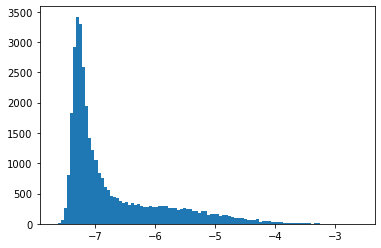

In [74]:
plt.hist(np.log10(energies), bins=100)
dm.seqlen

In [96]:
np.sum(energies > 1e-7)

15098

In [95]:
minp, maxp = 1e-7, 1e-6
idxs = np.where(np.logical_and(energies < maxp, energies > minp))[0]
idx = np.random.choice(idxs)
video_file, frame_ids = find_frame(dm.all_ds, idx)
clip_start, clip_end = int(frame_ids[0]), int(frame_ids[-1])

import tkinter as tk
from triplets import landmarks_video, triplets_gui

# video = video_dict[video_file]
video = landmarks_video.LandmarksVideo(video_file.parent, include_landmarks=True)
root = tk.Tk()
triplets_gui.Animation(root, frames=video[clip_start: clip_end], fps=60)
root.mainloop()

<ipython-input-6-bbde391b49e7>:6: DeprecationWarning: cummulative_sizes attribute is renamed to cumulative_sizes
  dataset_idx = bisect.bisect_right(ds.cummulative_sizes, idx)


In [5]:
import tkinter as tk
from triplets import landmarks_video, triplets_gui

# video = video_dict[video_file]
clip_start, clip_end = 90230, 90290
video_file = Path('/home/orel/Storage/Data/K7/2020-08-12/Down/0044.MP4')
video = landmarks_video.LandmarksVideo(video_file.parent, include_landmarks=True)
root = tk.Tk()
triplets_gui.Animation(root, frames=video[clip_start: clip_end], fps=60)
root.mainloop()

In [66]:
ff, Pxx = sig.periodogram(item.T, fs=dm.fps)

Pxx.shape, item.shape

((38, 31), (60, 38))

(6.596469e-08, 0.031055836006999016)

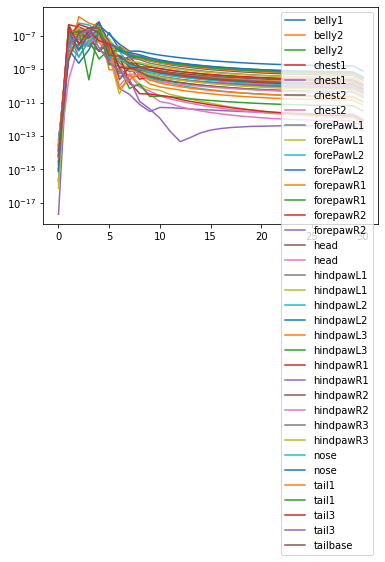

In [68]:
item = dm.all_ds[idx].reshape((60, -1))
# item -= item.mean(axis=0)
# plt.plot(item)
ff, Pxx = sig.periodogram(item.T, fs=dm.fps)
Pxx = Pxx.T
# energies[idx]
for ix in range(1, item.shape[1]-1):
    plt.semilogy(Pxx[:,ix], label=dm.data_frames[0].columns.levels[0][ix//2])
plt.legend()
Pxx[:10].mean(), energies[idx]

0

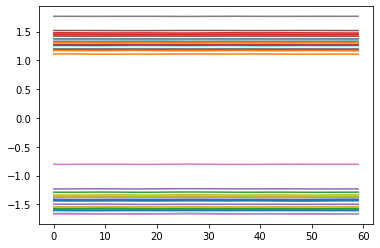

In [39]:
plt.plot(item)
0

In [12]:

video_dict = {video_file : landmarks_video.LandmarksVideo(video_file.parent, include_landmarks=True) for video_file in map(dataloader.find_video_file, dm.landmark_files)}

NameError: name 'video_dict' is not defined